This notebook has three sections:
1. Demo of stitching one pair and multiple pairs
2. Plot relationship of input beam centers and optimized centers
3. Normalization/Preprocessing of original tiles

In [1]:
from Image_Process import *
from scipy.ndimage import rotate

In [2]:
mrc_dir_path = '/central/scratch/hmmai_jensen_montage/data/MontTS/1.75umBeam/'
mask_dir = '/central/scratch/hmmai_jensen_montage/processing/1.75umBeam/masks/'
norm_im_dir = '/central/scratch/hmmai_jensen_montage/1.75umBeam_norm/'
stitched_dir = '/central/scratch/hmmai_jensen_montage/1.75umBeam_norm/test_stitched/'

pair_path = 'test_pairs.npy'
c_path = 'test_centers0.npy'

In [3]:
tilt_angle = 0
bound_p = 10 #pixels

In [4]:
pixel_size = 4.5160003
beam_diameter = 1.75 #um
# beam_centers = '0.0 0.0 -1.425357 -0.251329 -0.930335 1.108731 0.495021 1.360059 1.425357 0.251329 0.930335 -1.108731 -0.495021 -1.360059 -1.920378 -1.611388 -2.850713 -0.502658 -2.355692 0.857402 -1.860671 2.217461 -0.435314 2.46879 0.990042 2.720119 1.920378 1.611388 2.850713 0.502658 2.355692 -0.857402 1.860671 -2.217461 0.435314 -2.46879 -0.990042 -2.720119 -2.415399 -2.971448 -3.345734 -1.862717 -4.27607 -0.753986 -3.781048 0.606073 -3.286027 1.966132 -2.791006 3.326192 -1.36565 3.57752 0.059707 3.828849 1.485063 4.080178 2.415399 2.971448 3.345734 1.862717 4.27607 0.753986 3.781048 -0.606073 3.286027 -1.966132 2.791006 -3.326192 1.36565 -3.57752 -0.059707 -3.828849 -1.485063 -4.080178'
# beam_centers = beam_centers.split()
# beam_centers = np.array(beam_centers, dtype=float).reshape(-1,2)
# beam_centers *= 1e4/pixel_size
# # np.save('beam_centers_p.npy',beam_centers) 

beam_centers = np.load('beam_centers_p.npy',mmap_mode='r') #this file is already in unit of pixels

#### Stitch demo

In [9]:
#helper functions
'''
Determine which tiles overlap (from a pair) and save the pairs and initial 
guesses as .npy files.

Input:
------
centers: initial guesses of beam centers.

optional (only needed when verbose=True, to compare beam shift distances):
pixel_size: pixel spacing in .mrc file, in unit of Angstrom.
beam_diameter: in unit um.
beam_input: the input/intended beam centers. This must have same shape with
            centers.

'''
def prep_search(centers, pair_path='test_pairs.npy', c_path='test_centers0.npy', 
                verbose=True, pixel_size=None, beam_diameter=None, beam_input=None):
    if verbose:
        intended = beam_input*1e4/pixel_size
        for i in range(1, centers.shape[0]):
            intended_dist = np.sqrt(sum((intended[i,:]-intended[0,:])**2))
            print(f'Intended tile {i} and 0 dist={intended_dist}')
            now_dist = np.sqrt(sum((centers[i,:]-centers[0,:])**2))
            print(f'Now tile {i} and 0 dist={now_dist}')

    pairs = get_pairs(centers, beam_diameter*1e4/pixel_size)
    if verbose:
        print(f'pairs={pairs}')
        print(f'centers={centers}')
    np.save(pair_path, pairs)
    np.save(c_path, centers)
    
    
'''
Perform (verbose) greedy search. More documentation see opt_CC_greedy().
'''    
def search(im_dir, pair_path, c_path, mask_dir, tilt_angle, tile_inds, pixel_size,
           bound_p=10, n_processes=4, verbose=True):
    if verbose:
        print(f'num processes:{n_processes}') 
        print(f'searching +/- {bound_p*pixel_size/10} nm from initial guesses')
        initial_guesses = np.load(c_path,mmap_mode='r').copy()

    start_time=time.time()
    opt_c, cmat, nmat, disp = opt_CC_greedy(im_dir, pair_path, c_path, mask_dir, bound_p, tilt_angle, 
                                            tile_inds, debug=verbose, n_processes=n_processes)
    if verbose:
        print(f'time: {time.time() - start_time}s')
        print('displacement by')
        print(opt_c[1:,:] - initial_guesses[1:,:])
        print('Initial guesses')
        print(initial_guesses)
        print('Optimized centers')
        print(opt_c)
    return opt_c, cmat, nmat, disp
        
'''
Plot normalized CC matrices for the tile of interest.

Input:
------
See opt_CC_greedy() documentation of the outputs for opt_c, cmat, nmat, mods

TOI: Index of the tile of interest. Note that this only reflects which row of
     opt_c corresponds to this tile, rather than the actual index in the .mrc file.
mean: bool, whether get the mean CC matrix of all pairs that TOI was optimized 
      with respect to.
slic: list of indices, only intended to work when mean=False. Display the CC
      matrix between TOI and the tile indexed by slic. Note that this only reflects
      which row of opt_c corresponds to this tile, rather than the actual index in 
      the .mrc file.
clim: tuple of float, color min/max values for visualization.
'''
def plot_CC(cmat, nmat, initial_guesses, opt_c, TOI=1, mean=True, slic=[0], mods=None, clim=(-1,1)):    
    if mean: norm_c = np.array([(np.array(cmat[TOI-1])/np.array(nmat[TOI-1])).mean(axis=0)])
    else: 
        norm_c = (np.array(cmat[TOI-1])/np.array(nmat[TOI-1]))[slic,:,:]
        mods = mods[TOI-1][slic,:]
    
    for i in range(norm_c.shape[0]):
        plt.figure()
        plt.imshow(norm_c[i,:,:], cmap='coolwarm', extent=[initial_guesses[TOI,1]-bound_p,
                                                    initial_guesses[TOI,1]+bound_p,
                                                    initial_guesses[TOI,0]+bound_p,
                                                    initial_guesses[TOI,0]-bound_p])
        plt.plot(initial_guesses[TOI,1], initial_guesses[TOI,0],'go', alpha=0.3,markersize=3)
        
        if mean: 
            plt.plot(opt_c[TOI,1], opt_c[TOI,0],'go', markersize=3)
            plt.title(f'mean normalized CC for tile {TOI}')
        else: 
            plt.plot(initial_guesses[TOI,1]+mods[i,1], initial_guesses[TOI,0]+mods[i,0],
                     'go', markersize=3)
            plt.title(f'normalized CC for tile {TOI} and the {slic[i]}th tile') 
            #note that slic[i] is not tile ind. To find that, see the following debug output
            #from opt_greedy_search(): "greedy at tile {TOI} with relevant pairs ..."
        plt.clim(clim[0],clim[1])
        plt.colorbar()

##### (a) One pair (Tile 0 and 6)

In [10]:
#array value was obtained from manual stitch in Midas (y-translation value first, x-translation value second)
#5.625 is because Midas compress oiginal tile shape (4092, 5760) to (727, 1024), which is 5.625x
centers = np.array(np.array([[    0,     0],
                             [520, 252]])*5.625, dtype=int) #520=y-translation, 252=x-translation of tile 6
print(centers)
tile_inds = [0,6]

prep_search(centers, pixel_size=pixel_size, beam_diameter=beam_diameter, beam_input=beam_centers[:7:6,:])

[[   0    0]
 [2925 1417]]
Intended tile 1 and 0 dist=7096823.6181382565
Now tile 1 and 0 dist=3250.1559962561796
pairs=[(0, 1)]
centers=[[   0    0]
 [2925 1417]]


In [12]:
opt_c, cmat, nmat, disp = search(norm_im_dir, pair_path, c_path, mask_dir, tilt_angle, tile_inds, pixel_size, bound_p)

num processes:4
searching +/- 4.5160003 nm from initial guesses
greedy at tile 6 with relevant pairs [(0, 6)]
center 1 (tile 6) mat_ijs=[[ 5 15]]
mean perturbed mat_i=5.0 mat_j=15.0
time: 50.94490456581116s
displacement by
[[-5  5]]
Initial guesses
[[   0    0]
 [2925 1417]]
Optimized centers
[[   0    0]
 [2920 1422]]


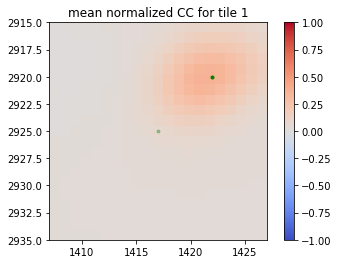

In [13]:
plot_CC(cmat, nmat, centers, opt_c)

##### (b) Multiple pairs (Tile 0,1,2)

In [34]:
# tile_inds = [0,1,2]
# centers = np.array([[-231, 126],
#                     [2980, 350],
#                     [1550, -2550]])
tile_inds = [0,1,2,3]
centers = np.array([[0, 0],
                    [3212,224],
                    [1781, -2676], 
                    [-1440,-2896]])

centers = centers[:,::-1]
prep_search(centers, pixel_size=pixel_size, beam_diameter=beam_diameter, 
            beam_input=beam_centers[:4,:])

Intended tile 1 and 0 dist=7096827.97109081
Now tile 1 and 0 dist=3219.801236101384
Intended tile 2 and 0 dist=7096825.936530543
Now tile 2 and 0 dist=3214.488606294942
Intended tile 3 and 0 dist=7096823.6181382565
Now tile 3 and 0 dist=3234.2566379308864
pairs=[(0, 1), (0, 2), (0, 3), (1, 2), (2, 3)]
centers=[[    0     0]
 [  224  3212]
 [-2676  1781]
 [-2896 -1440]]


In [35]:
opt_c, cmat, nmat, disp = search(norm_im_dir, pair_path, c_path, mask_dir, tilt_angle, tile_inds, pixel_size, bound_p)

num processes:4
searching +/- 4.5160003 nm from initial guesses
greedy at tile 1 with relevant pairs [(0, 1)]
center 1 (tile 1) mat_ijs=[[ 8 10]]
mean perturbed mat_i=8.0 mat_j=10.0
greedy at tile 2 with relevant pairs [(0, 2), (1, 2)]
center 2 (tile 2) mat_ijs=[[ 9 12]
 [ 3 10]]
mean perturbed mat_i=6.0 mat_j=11.0
greedy at tile 3 with relevant pairs [(0, 3), (2, 3)]
center 3 (tile 3) mat_ijs=[[ 6 17]
 [ 9 17]]
mean perturbed mat_i=8.0 mat_j=17.0
time: 270.5517010688782s
displacement by
[[-2  0]
 [-4  1]
 [-2  7]]
Initial guesses
[[    0     0]
 [  224  3212]
 [-2676  1781]
 [-2896 -1440]]
Optimized centers
[[    0     0]
 [  222  3212]
 [-2680  1782]
 [-2898 -1433]]


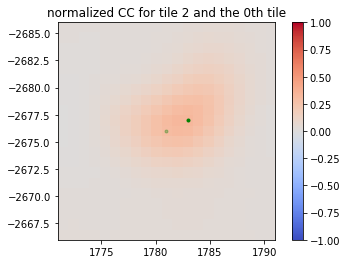

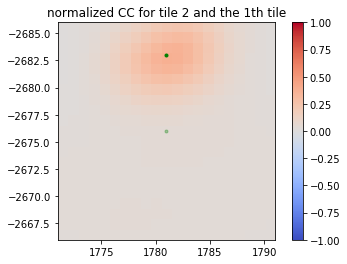

In [43]:
TOI = 2
plot_CC(cmat, nmat, centers, opt_c, TOI, mean=False, slic=[0,1], mods=disp)

[ 8392 10766]
before centering canvas: [[  126  -231]
 [  348  2981]
 [-2554  1551]]
after centering canvas: [[5015 3718]
 [5237 6930]
 [2335 5500]]


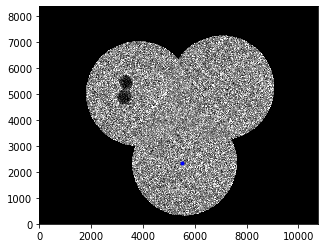

In [22]:
stitched = stitch(opt_c.copy(), tile_shape=(4092, 5760), im_path=mrc_dir_path, tile_inds=[0,1,2],
                  mask_dir=mask_dir, tilt_angle=0)

In [10]:
save_mrc(stitched, stitched_dir+'opt012.mrc')

In [5]:
# if get initial guesses based on rotating input beam centers:

# centers = beam_centers[:3,:].copy() # centers = beam_centers[:4:3,:].copy()
# centers = centers.dot(R)
# centers = centers[:,::-1]
# centers = np.array(centers, dtype=int)
# centers

array([[    0,     0],
       [  223,  3197],
       [-2657,  1792]])

In [8]:
# Other ideas sketch
# iterative : if opt_c too close to boundary (<3 pixels), do a second iteration? or smaller search
# if opt_c correspond to normalized cc < 0.2, do a second interation 
# by second iteration, still doesn't work, then mark as failure?

#### Relationship of optimized centers and beam input positions

In [5]:
from matplotlib.patches import Rectangle

In [16]:
theta=np.radians(186)
c, s = np.cos(theta), np.sin(theta)
R = np.array(((c, -s), (s, c)))

In [17]:
# centers = np.array([[0, 0],
#                     [222, 3212],
#                     [-2677,  1783], #[-2551,  1552]-[  126,  -231]
#                     [-2920, -1422]])
centers = np.array([[    0,     0],
                    [  222,  3212],
                    [-2680,  1782],
                    [-2898, -1433]])
centers = centers[:,::-1]
centers -= centers[0,:]

In [18]:
beam_input = beam_centers[:centers.shape[0],:]
beam_input

memmap([[    0.        ,     0.        ],
        [-3156.23763179,  -556.53008177],
        [-2060.08623606,  2455.11721325],
        [ 1096.14918138,  3011.64508067]])

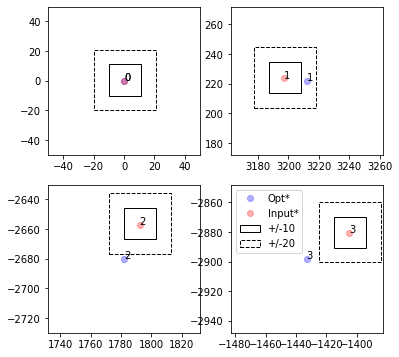

In [28]:
subplot_shape = (2,2)
fig,ax = plt.subplots(subplot_shape[0],subplot_shape[1], figsize=(6,6))

bound_p = 10
annotations = np.arange(centers.shape[0])
ann_dis = 0
# ann_dis = np.array([20,20]) #to visualize annotation better
lim_dis = 50 #for centering the subplot at the beam center
for i in range(len(annotations)):
    ind = np.unravel_index(i, subplot_shape)
    ax[ind].plot(centers[i,0], centers[i,1], 'bo', alpha=0.3) #tile 0 has coordinate (0,0)
    ax[ind].plot(beam_input.dot(R)[i,0], beam_input.dot(R)[i,1], 'ro', alpha=0.3) #rotated input
    
    ax[ind].annotate(annotations[i], centers[i,:]+ann_dis)
    ax[ind].annotate(annotations[i], beam_input.dot(R)[i,:]-ann_dis)
    rect = Rectangle(beam_input.dot(R)[i,:]-np.array([bound_p, bound_p]), 
                     2*bound_p+1,2*bound_p+1, edgecolor='k',facecolor='none')
    rect2 = Rectangle(beam_input.dot(R)[i,:]-np.array([2*bound_p, 2*bound_p]), 
                     2*2*bound_p+1,2*2*bound_p+1, ls='--',
                     edgecolor='k',facecolor='none')
    ax[ind].add_patch(rect)
    ax[ind].add_patch(rect2)
#     ax[ind].legend(['Opt*','Input*'])
    ax[ind].set_ylim([centers[i,1]-lim_dis,centers[i,1]+lim_dis])
    ax[ind].set_xlim([centers[i,0]-lim_dis,centers[i,0]+lim_dis])
    
plt.legend(['Opt*','Input*','+/-10','+/-20'])

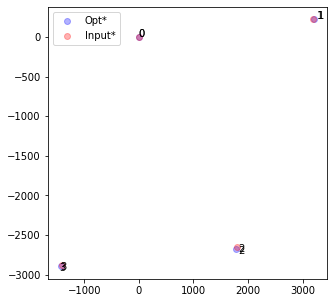

In [27]:
plt.figure(figsize=(5,5))
plt.plot(centers[:,0], centers[:,1], 'bo', alpha=0.3)
plt.plot(beam_input.dot(R)[:,0], beam_input.dot(R)[:,1], 'ro', alpha=0.3)

plt.legend(['Opt*','Input*'])
annotations = np.arange(centers.shape[0])
for i in range(len(annotations)):
    plt.annotate(annotations[i], centers[i,:]*1.02)
    plt.annotate(annotations[i], beam_input.dot(R)[i,:]*1.02)

#### Normalize tiles by taking the mean and std of all tiles for ONE tilt angle

In [14]:
import glob
def get_mean_of_tilt(mrc_dir, mask_dir, tilt_angle):
    p_counts = 0
    I_tot = 0
    for mrc_file in glob.glob(mrc_dir+f'*_{tilt_angle}_*.mrc'):
        mrc = mrcfile.open(mrc_file,'r')
        tile = mrc.data.copy()
        mrc.close()
        
        tile_ind = mrc_file.split('_')[-1][:-4]
        mask = np.load(mask_dir+f'Xgrating2_{tilt_angle}_{tile_ind}.npy', mmap_mode='r')
        beam = np.array(mask, dtype=bool)
        p_counts += mask.sum()
        I_tot += tile[beam].sum()
    return I_tot/p_counts

def get_std_of_tilt(mrc_dir, mask_dir, tilt_angle, mu):
    p_counts = 0
    var_tot = 0
    for mrc_file in glob.glob(mrc_dir+f'*_{tilt_angle}_*.mrc'):
        mrc = mrcfile.open(mrc_file,'r')
        tile = mrc.data.copy()
        mrc.close()
        
        tile_ind = mrc_file.split('_')[-1][:-4]
        mask = np.load(mask_dir+f'Xgrating2_{tilt_angle}_{tile_ind}.npy', mmap_mode='r')
        beam = np.array(mask, dtype=bool)
        p_counts += mask.sum()
        var_tot += sum((tile[beam]-mu)**2)
    return np.sqrt(var_tot/(p_counts-1))

def process_tiles_of_tilt(mrc_dir, mask_dir, tilt_angle, out_dir, mu, std):
    for mrc_file in glob.glob(mrc_dir+f'*_{tilt_angle}_*.mrc'):
        mrc = mrcfile.open(mrc_file,'r')
        tile = mrc.data.copy()
        mrc.close()
        
        tile_ind = mrc_file.split('_')[-1][:-4]
        mask = np.load(mask_dir+f'Xgrating2_{tilt_angle}_{tile_ind}.npy', mmap_mode='r')
        corner = np.array(1-mask, dtype=bool)
        tile[corner] = 0
        tile = ma.masked_array(tile, corner)
        tile = preprocess(tile, mu, std)
        save_mrc(tile.data, out_dir+f'Xgrating2_{tilt_angle}_{tile_ind}.mrc')
#         np.save(out_dir+f'Xgrating2_{tilt_angle}_{tile_ind}.npy', tile.data)
        print(f'Tile {tile_ind} mean: {tile.mean()} std: {tile.std()}')

In [6]:
mu = get_mean_of_tilt(mrc_dir_path,mask_dir, 0)
print(mu)

379.8169817989392

In [7]:
std = get_std_of_tilt(mrc_dir_path, mask_dir, 0, mu)
print(std)

107.76934237428094

In [16]:
out_dir='/central/scratch/hmmai_jensen_montage/1.75umBeam_norm/'
process_tiles_of_tilt(mrc_dir_path, mask_dir, 0, out_dir, mu, std)

Tile 13 mean: 0.006642712242225475 std: 0.9962220608310278
Tile 14 mean: 0.01665145937364819 std: 0.9944493892321598
Tile 16 mean: 0.012714617756898725 std: 0.9893000287020405
Tile 33 mean: -0.01533779993754953 std: 0.9790464213120321
Tile 0 mean: -0.02897014118556019 std: 1.052139007286906
Tile 24 mean: -0.013090686127867943 std: 1.00688421413913
Tile 18 mean: 0.010032372471010853 std: 0.9937846529652203
Tile 26 mean: -0.07637184349836451 std: 1.0406870343989207
Tile 17 mean: 0.013776346713024948 std: 0.9968514903712261
Tile 6 mean: 0.01768923816026488 std: 1.0007421460024444
Tile 11 mean: 0.014989891051912224 std: 0.9985178317027339
Tile 4 mean: 0.017725579151835605 std: 0.9949585771853364
Tile 20 mean: -0.013314818379036754 std: 1.0113018404470042
Tile 5 mean: 0.012107354342396811 std: 0.989889397581144
Tile 12 mean: 0.011765169070018731 std: 1.0026082755488313
Tile 31 mean: 0.004414853877996295 std: 0.9839274697257991
Tile 32 mean: 0.0009796907736489644 std: 0.9817809468202666
Tile

In [20]:
# I previously stored normalized tiles as .npy, this code is to correct them to .mrc
# for npy_file in glob.glob(norm_npy_dir+f'*.npy'):
#     norm_tile = np.load(npy_file, mmap_mode='r')
#     save_mrc(norm_tile, npy_file[:-3]+'mrc')

In [ ]:
# obsolete code used to compare beam input and mrc headers
# with open('tilts_centers.txt','w') as f_centers:
#     with open('montage1.txt', 'r') as f_beam:
#         for line in f_beam:
#             tilt_angle = line.split()[0]
#             print(f'TiltAngle: {tilt_angle}')
#             f_centers.write(f'TiltAngle: {tilt_angle}\n')

#             beam_centers = line.split()[1:]
#             beam_centers = np.array(beam_centers, dtype=float).reshape(-1,2)
#             for i in range(beam_centers.shape[0]):
#                 with open(mrc_dir_path+f'Xgrating2_{tilt_angle}_{i}.mrc.mdoc', 'r') as f_mrc:
#                     for line in f_mrc:
#                         if 'ImageShift' in line: 
#                             f_centers.write(f'Tile {i}: Beamcenter={beam_centers[i,:]}\n')
#                             im_shift = np.array(line.split('=')[1].split(), dtype=float)
#                             f_centers.write(f'Tile {i}: ImageShift={im_shift}\n')
#             f_centers.write('\n')